In [1]:
%load_ext autoreload
%autoreload 2    
# Autoreload isn't working for the ssg stuff,
# unclear why, I think it has too many layers of imports.

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.tree import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.torch_utils import *
from spatial_scene_grammars.neural_grammar_proposal import *

from spatial_scene_grammars_examples.planar_box_stacks.grammar import *

torch.manual_seed(42)

In [2]:
# Make a bigger dataset of observed trees, and prepare meta-tree.
full_trees_for_training = []
observed_nodes_for_training = []
def make_dataset(N=100):
    full_trees = []
    observed_nodes = []
    for k in range(N):
        scene_trees, success = sample_tree_from_root_type_with_constraints(
            root_node_type=Ground,
            root_node_instantiation_dict={
                "xy": torch.tensor([0., 0.])
            },
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            continue
        full_trees.append(scene_trees[0])
        observed_nodes.append([n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)])
    return full_trees, observed_nodes
full_trees_for_training, observed_nodes_for_training = make_dataset(500)
full_trees_for_testing, observed_nodes_for_testing = make_dataset(250)
meta_tree = SceneTree.make_meta_scene_tree(Ground())

In [3]:
# Load encoder from saved run.
encoder = GrammarEncoder(meta_tree, 512)
weight_path = "saved_models/20210319/encoder_supervised_2.5792.torch"
#weight_path = "saved_models/20210319/encoder_unsupervised_-6.0246.torch"
encoder.load_state_dict(torch.load(weight_path))
encoder.eval()
x = encoder(observed_nodes_for_training[0])

Grammar tuning given a neural proposal engine:

The most direct and appealing approach would be: can I just encode everything in my dataset and convert the meta-tree encoding to grammar encodings? The core question is how to back out the equivalent restricted-grammar params for a set of meta-tree params. Continuous values are already done (the mean-field approx is organized per-node-type). Discrete values require combination across the places the node in question appears in the meat-scene tree: I *think* simple weighted-averaging across the node's appearances will work. Weighting is by how often that node is going to appear in the final grammar, which we can calculate by looking at the parent production probs.

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


Err:  tensor(0.2389, grad_fn=<SumBackward0>)
Err:  tensor(0.5416, grad_fn=<SumBackward0>)
Err:  tensor(0.3897, grad_fn=<SumBackward0>)
Err:  tensor(0.2063, grad_fn=<SumBackward0>)
Err:  tensor(0.5701, grad_fn=<SumBackward0>)
Err:  tensor(11.9115, grad_fn=<SumBackward0>)
Err:  tensor(0.9230, grad_fn=<SumBackward0>)
Err:  tensor(0.2747, grad_fn=<SumBackward0>)
Err:  tensor(0.3539, grad_fn=<SumBackward0>)
Err:  tensor(29.5930, grad_fn=<SumBackward0>)


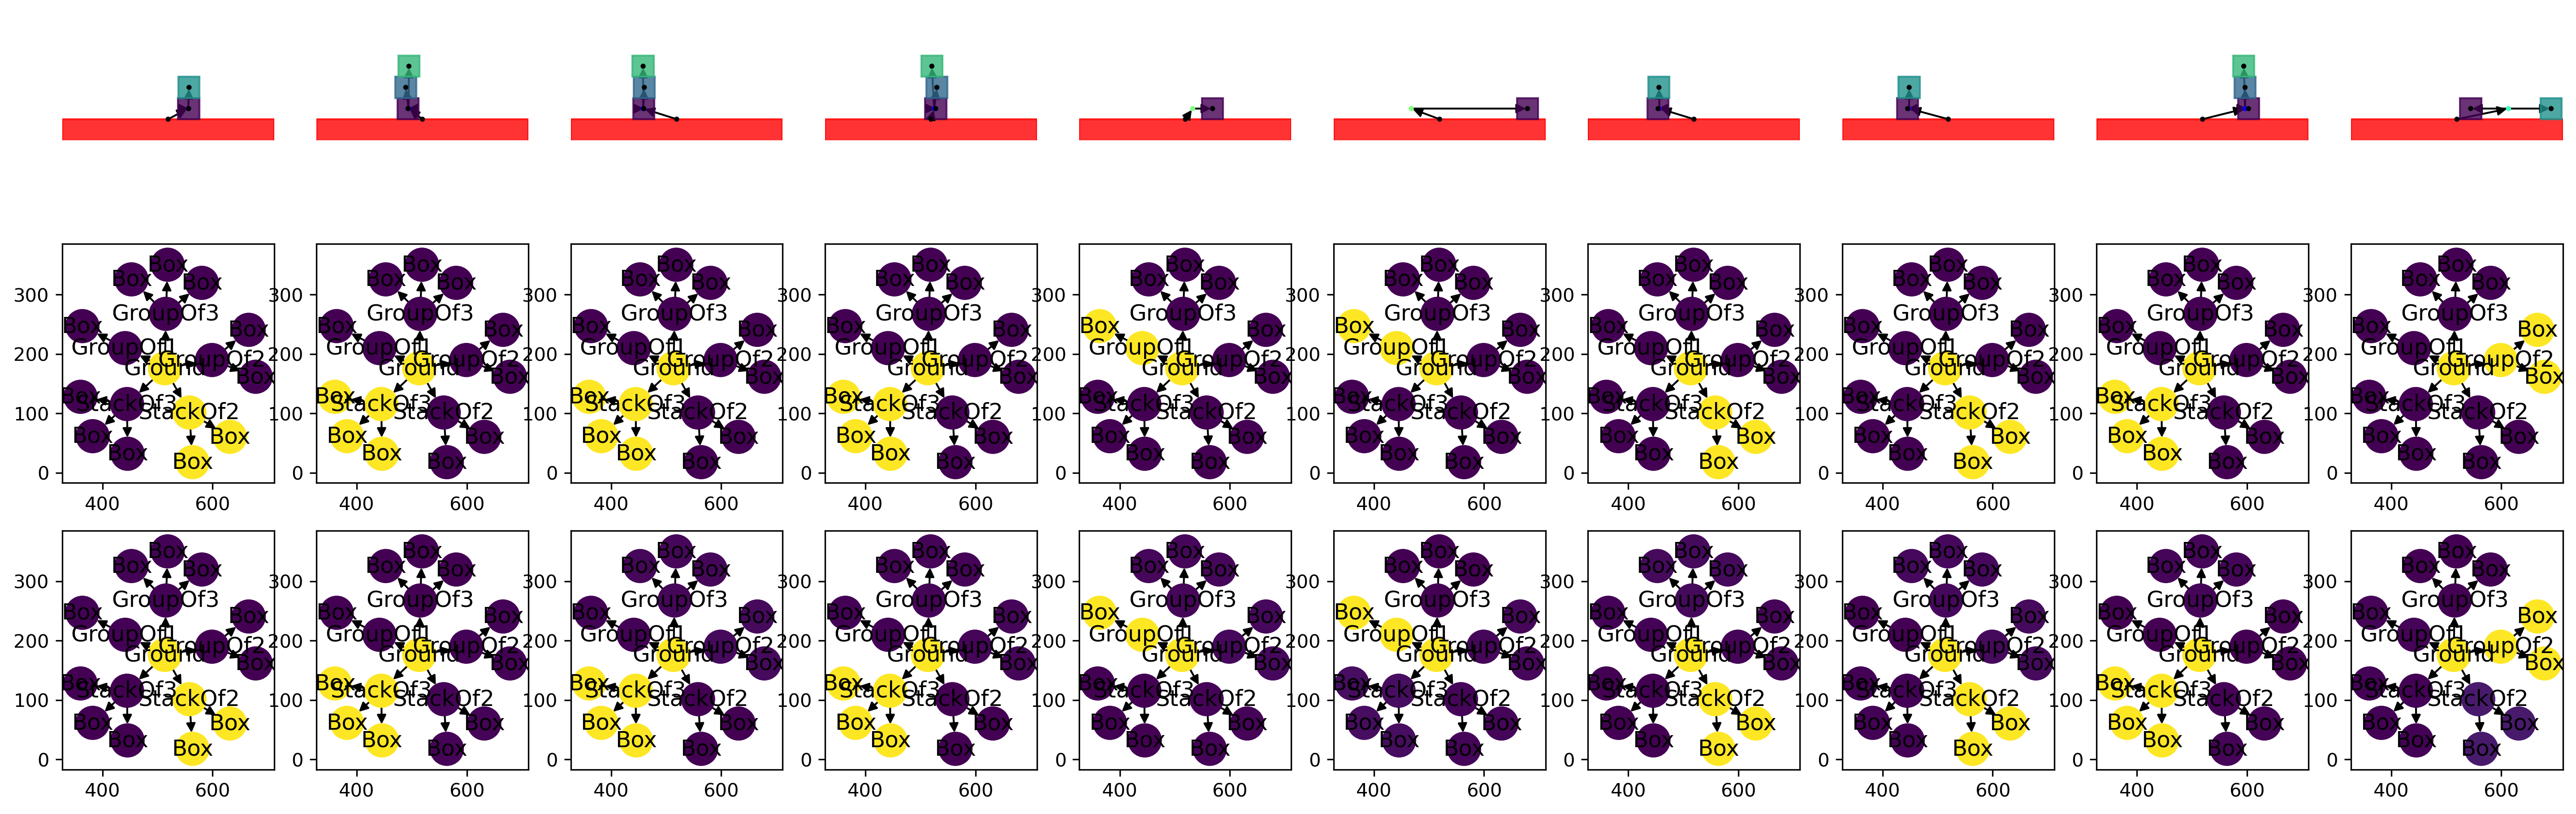

In [4]:
# Utility we'll need for collating tree info.

from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300).set_size_inches(24, 8)
N = 5
for k in range(N):
    plt.subplot(3, N, k + 1)
    draw_boxes(full_trees_for_training[k], fig=plt.gcf(), ax=plt.gca(), block=False)
    def draw(x):
        inclusion_log_likelihood_per_node, _ = encoder.get_product_weights_and_inclusion_lls(meta_tree, x)
        nx.draw_networkx(
            meta_tree,
            ax=plt.gca(),
            pos = graphviz_layout(meta_tree),
            labels={node: node.__class__.__name__ for node in meta_tree},
            node_color=[inclusion_log_likelihood_per_node[node] for node in meta_tree]
        
    )
    plt.subplot(3, N, N + k + 1)
    x_target = encoder.get_grammar_parameters_from_actual_tree(meta_tree, full_trees_for_training[k])
    draw(x_target)
    plt.subplot(3, N, 2*N + k + 1)
    x = encoder(observed_nodes_for_training[k])
    draw(x)
    
    # Penalize distance for non-nan terms
    target_mask = torch.isfinite(x_target)
    err = (x - x_target)[target_mask].square().sum()
    print("Err: ", err)


In [9]:
# Encode every observation in the training set. For each observation, we'll
# get a dist over the meta-tree grammar. From these, we can extract
# distributions (on a per-node-of-the-meta-tree level) distributions over
# child sets and node attributes. These are *not* currently the same as
# the actual node grammar parameters. I think it's high time I cleaned that
# up and made declaration of parameters explicit?

# Each of these are keyed by node type, with lists of distributions
# as value.
#local_variable_dists_by_node_type = {}
#derived_variable_dists_by_node_type = {}
product_weight_dists_by_node_type = {}

for node in meta_tree:
    node_type = type(node)
    if node_type not in local_variable_dists_by_node_type.keys():
#        local_variable_dists_by_node_type[node_type] = list()
#        derived_variable_dists_by_node_type[node_type] = list()
        product_weight_dists_by_node_type[node_type] = list()
all_node_types = list(local_variable_dists_by_node_type.keys())

for observed_nodes in observed_nodes_for_training:
    x = encoder(observed_nodes)
    inclusion_ll_per_node, product_weights_per_node = \
        encoder.get_product_weights_and_inclusion_lls(meta_tree, x)
    
    for node_type in all_node_types:
        # Extract and combine product weight dists into one distribution.
        all_weights = []
        all_inclusion_lls = []
        for meta_node in meta_tree.nodes:
            if isinstance(meta_node, node_type):
                all_inclusion_lls.append(inclusion_ll_per_node[meta_node])
                all_weights.append(product_weights_per_node[meta_node])

        all_weights = torch.stack(all_weights) # N x n children
        all_inclusion_lls = torch.tensor(all_inclusion_lls)
        
        print(all_weights, all_inclusion_lls, all_weights.shape)
        break
    break
        
    # Extract product weight dists:
    if isinstance(meta_node, NonTerminalNode) and not isinstance(meta_node, AndNode):
        assert isinstance(meta_node, NonTerminalNode)
        inds = encoder.node_output_info[meta_node].product_weight_inds
        raw_product_weights = x[inds]
        if isinstance(meta_node, OrNode):
            product_weights = torch.nn.functional.softmax(raw_product_weights, dim=0)
        elif isinstance(meta_node, IndependentSetNode):
            product_weights = torch.sigmoid(raw_product_weights)
        elif isinstance(meta_node, GeometricSetNode):
            # Choose count
            product_weights = torch.nn.functional.softmax(raw_product_weights, dim=0)
        else:
            raise NotImplementedError("Don't know how to decode Nonterminal type %s" % meta_node.__class__.__name__)
        product_weights_per_node[meta_node] = product_weights

            
        

tensor([[1.0000e+00, 1.9310e-09, 2.2041e-09, 2.2235e-09, 2.2466e-09]],
       grad_fn=<StackBackward>) tensor([0.]) torch.Size([1, 5])
